# Reproducing Figure 4

In this figure, we vary configuration 1 as follows:

* Number of delivery beds: 2 or 3
* Delivery arrivals: 1, 1.5 or 2 per day
    * 1 = IAT 1440 (as in e.g. config1)
    * 1.5 = 960 (as 720+240=960, and 960+480=1440)
    * 2 = IAT 720 (as we did for Figure 3)

## Set up

In [1]:
# To run model
import PHC

# To import results and produce figures
import xlrd
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import itertools

# To speed up run time
from multiprocessing import Pool

# Additional package to record runtime of this notebook
import time
start = time.time()

In [2]:
# Paths to save image files to
output_folder = 'outputs'
fig4_path = os.path.join(output_folder, 'fig4.png')

## Run model

In [3]:
# TODO: Run with 100 replications

# Varying number of childbirth cases
arr_dict = [
    {
        'delivery_iat': 1440,
        'replication': 10,
        'rep_file': 'arr1440'
    },
    {
        'delivery_iat': 1080,
        'replication': 10,
        'rep_file': 'arr960'
    },
    {
        'delivery_iat': 720,
        'replication': 10,
        'rep_file': 'arr720'
    }
]

# Varying the number of beds
bed_dict = [
    {
        'delivery_bed_n': 1,
        'rep_file': 'bed1'
    },
    {
        'delivery_bed_n': 2,
        'rep_file': 'bed2'
    }
]

Create each combination for the reproduction

In [4]:
dict_list = []
for arr in arr_dict:
    for bed in bed_dict:
        # Combine the dictionaries
        comb = {**arr, **bed}
        # Replace the file name
        comb['rep_file'] = f'''f4_{arr['rep_file']}_{bed['rep_file']}.xls'''
        # Save to list
        dict_list.append(comb)

len(dict_list)

6

In [5]:
# Append 's_' to all items
for i, d in enumerate(dict_list):
    dict_list[i] = {f's_{k}': v for k, v in d.items()}

# Preview example
dict_list[0]

{'s_delivery_iat': 1440,
 's_replication': 10,
 's_rep_file': 'f4_arr1440_bed1.xls',
 's_delivery_bed_n': 1}

Run the model (with parallel processing to reduce run time)

In [6]:
# Wrapper function to allow input of dictionary with pool
def wrapper(d):
    return PHC.main(**d)

# Create a process pool that uses all CPUs
with Pool() as pool:
    # Run PHC.main() using each of inputs from config
    pool.map(wrapper, dict_list)

 No of replications done 0
 No of replications done 0
 No of replications done 0
 No of replications done 0
 No of replications done 0
 No of replications done 0
 No of replications done 1
 No of replications done 1
 No of replications done 1
 No of replications done 1
 No of replications done 1
 No of replications done 1
 No of replications done 2
 No of replications done 2
 No of replications done 2
 No of replications done 2
 No of replications done 2
 No of replications done 2
 No of replications done 3
 No of replications done 3
 No of replications done 3
 No of replications done 3
 No of replications done 3
 No of replications done 3
 No of replications done 4
 No of replications done 4
 No of replications done 4
 No of replications done 4
 No of replications done 4
 No of replications done 4
 No of replications done 5
 No of replications done 5
 No of replications done 5
 No of replications done 5
 No of replications done 5
 No of replications done 5
 No of replications done 6
 

## Process results

In [7]:
def process_results(files):
    '''
    Imports files in provided list and produces a single dataframe with mean
    results from across the replications

    Parameters:
    ----------
    files : list
        List of file names (exc. file type) containing replication results

    Returns:
    --------
    summary : dataframe
        Dataframe with mean results for each model variant in file list
    '''
    # Empty list to store results
    result_list = []

    for f in files:
        # Import .xls and convert to pandas dataframe
        book = xlrd.open_workbook(os.path.join(output_folder, f))
        result = pd.read_excel(book, header=None, index_col=0)

        # Add proportion of childbirth cases referred
        result.loc['prop_del_referred'] = (
            result.loc['del referred'] / result.loc['Del patients'])

        # Find mean from the replication
        # Save as dataframe, dropping the duplicate rows (NCD occ twice)
        res = pd.DataFrame({f: result.mean(axis=1)}).drop_duplicates()

        # Remove index name
        res.index.name = None

        # Remove .xls from column names
        res.columns = res.columns.str.removesuffix('.xls')

        # Save to list
        result_list.append(res)

    # Combine into single dataframe
    summary = pd.concat(result_list, axis=1)

    return summary

In [8]:
data = process_results([i['s_rep_file'] for i in dict_list])
data.head()

,f4_arr1440_bed1,f4_arr1440_bed2,f4_arr960_bed1,f4_arr960_bed2,f4_arr720_bed1,f4_arr720_bed2
OPD patients,33147.900000,33113.500000,33128.700000,33109.500000,33171.600000,33145.000000
IPD patients,184.900000,175.800000,187.000000,173.000000,175.800000,184.500000
ANC patients,359.800000,365.600000,366.300000,359.900000,354.500000,367.600000
Del patients,368.700000,375.400000,479.300000,486.800000,739.500000,725.600000
OPD Q wt,0.007587,0.008618,0.013482,0.011329,0.016205,0.018053


## Create Figure 4

In [9]:
# Select series with proportion referred
a4 = data.loc['prop_del_referred']

# Reshape into appropriate format for plotting
names = ['1', '1.5', '2']
bed1 = [a4['f4_arr1440_bed1'], a4['f4_arr960_bed1'], a4['f4_arr720_bed1']]
bed2 = [a4['f4_arr1440_bed2'], a4['f4_arr960_bed2'], a4['f4_arr720_bed2']]

data_4a = pd.DataFrame({'1 bed': bed1, '2 beds': bed2}, index=names)
data_4a

,1 bed,2 beds
1,0.154491,0.022222
1.5,0.194728,0.030101
2,0.279158,0.058934


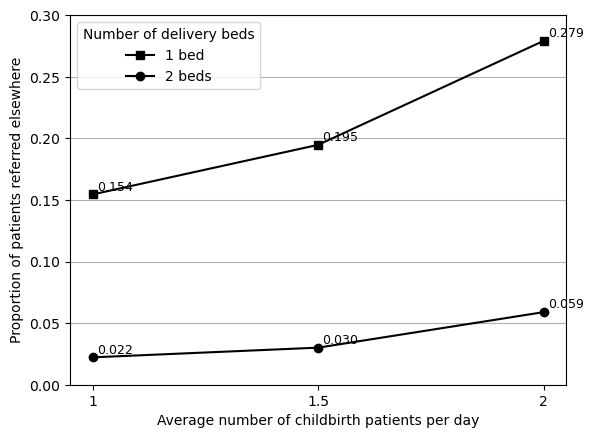

In [10]:
# Plot data
ax = data_4a.plot(kind='line', color='black')

# Add markers
for l, ms in zip(ax.lines, itertools.cycle('so')):
    l.set_marker(ms)
    l.set_color('black')
ax.legend(title='Number of delivery beds')

# Add labels to each point
for line in ax.lines:
    x_data = line.get_xdata()
    y_data = line.get_ydata()
    for x, y in zip(x_data, y_data):
        ax.annotate(f'{y:.3f}', xy=(x, y), xytext=(3, 3),
                    textcoords='offset points', fontsize=9)

# Adjust figure
plt.xlabel('Average number of childbirth patients per day')
plt.ylabel('Proportion of patients referred elsewhere')
plt.ylim(0, 0.3)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.savefig(fig4_path, bbox_inches='tight')
plt.show()

In [25]:
# Input results from original and reproduced figures
comp = pd.DataFrame({
    'original': [0.021, 0.039, 0.0599, 0.150, 0.195, 0.270],
    'reproduced': data_4a.iloc[:, 1].to_list() + data_4a.iloc[:, 0].to_list()})
comp['reproduced'] = round(comp['reproduced'], 3)

# Find size of difference and % change
comp['diff'] = comp['reproduced'] - comp['original']
comp['pct_change'] = comp.pct_change(axis=1).iloc[:, 1]*100
comp

,original,reproduced,diff,pct_change
0,0.0210,0.022,0.0010,4.761905
1,0.0390,0.030,-0.0090,-23.076923
2,0.0599,0.059,-0.0009,-1.502504
3,0.1500,0.154,0.0040,2.666667
4,0.1950,0.195,0.0000,0.000000
5,0.2700,0.279,0.0090,3.333333


## Run time

In [13]:
# Find run time in seconds
end = time.time()
runtime = round(end-start)

# Display converted to minutes and seconds
print(f'Notebook run time: {runtime//60}m {runtime%60}s')

Notebook run time: 2m 27s
